General Info: 
- min. Python Version 3.6 for Rocketpy(conda environment with python 3.11.3 used here)
- recommened min. python version: 3.11.0 (required for the netCFD4-package version 1.6.2)
- Environment: Conda - RocketPy (includes all required packages as recommended in the documentation)

see: https://docs.rocketpy.org/en/latest/user/requirements.html

    Imports

In [1]:
# from logging import root
# from tkinter import Widget
# import matplotlib as plt
from rocketpy import Environment, SolidMotor, Rocket, Flight 

# %matplotlib Widget

    Setting up the simulation

In [2]:
#some definitions
class launchRail():
    railLength=6.5     #m
    railOrientation=88   #º inclination with respect to ground

Add an Environment (e.g. MUNICH)

In [3]:
Env = Environment(
    railLength=launchRail.railLength, 
    latitude=32.99, 
    longitude=50, 
    elevation=5
    )
    
# #get weather data 
# import datetime

# tomorrow = datetime.date.today() + datetime.timedelta(days=1)
# Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12)) #Hours given in UTC time 

# #Tell Env to use forcasted weather to get atmosphereic conditions for flight 
# Env.setAtmosphericModel(type="Forecoasst", file="GFS")
# #see weather info 
# Env.info() 

Create a Motor 


Motor Details
Total Burning Time: 4.5 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 261.462 m/s
Average Thrust: 171.746 N
Maximum Thrust: 313.71 N at 0.47 s after ignition.
Total Impulse: 772.857 Ns

Plots


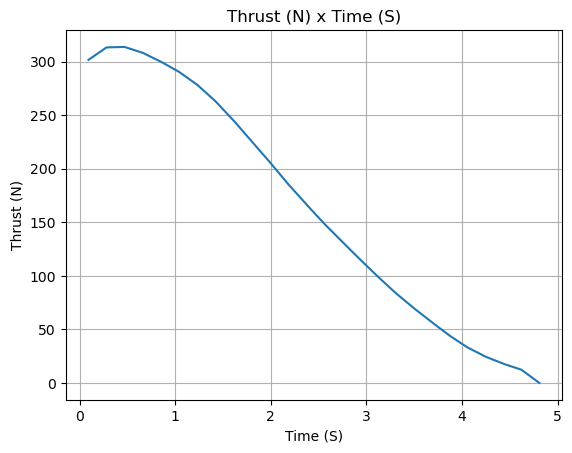

In [9]:
# solid motor class requires thurst curve from .eng or .csv file and other param. 
J180T = SolidMotor(
    thrustSource="../motors/AeroTech_J180T.csv",
    burnOut=4.5,
    grainNumber=5,
    grainSeparation=5/1000, 
    grainDensity=1815, 
    grainOuterRadius=33/1000,
    grainInitialInnerRadius=15/1000, 
    grainInitialHeight=120/1000, 
    nozzleRadius=33/1000,
    throatRadius=11/1000, 
    interpolationMethod="linear" #other interpolation methods dont work
)
J180T.info()

Create a Rocket

Inertia Details
Rocket Mass: 20.000 kg (No Propellant)
Rocket Mass: 22.956 kg (With Propellant)
Rocket Inertia I: 6.000 kg*m2
Rocket Inertia Z: 0.050 kg*m2

Geometrical Parameters
Rocket Maximum Radius: 0.1 m
Rocket Frontal Area: 0.031416 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: 1 m
Rocket Center of Mass - Motor reference point: -1 m
Rocket Center of Mass - Rocket Loaded Center of Mass: -0.129 m

Aerodynamic Components Parameters
Currently not implemented.

Aerodynamics Lift Coefficient Derivatives
Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 13.599/rad

Aerodynamics Center of Pressure
Nose Cone Center of Pressure to CM: 2.030 m
Fins Center of Pressure to CM: -1.028 m
Distance - Center of Pressure to CM: -0.636 m
Initial Static Margin: 2.534 c
Final Static Margin: 3.175 c

Mass Plots


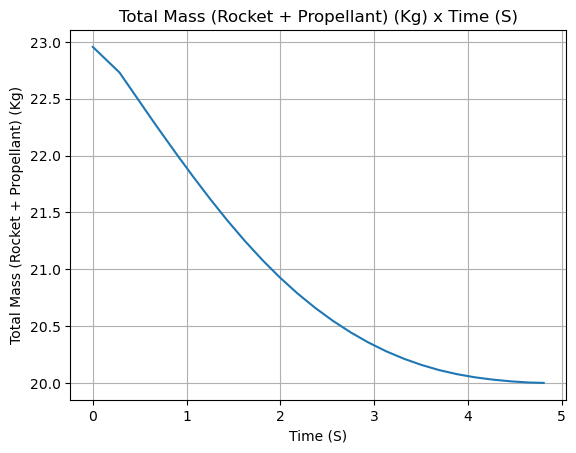

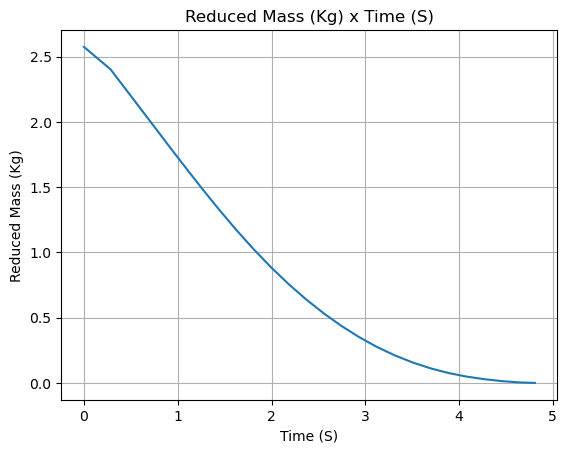


Aerodynamics Plots


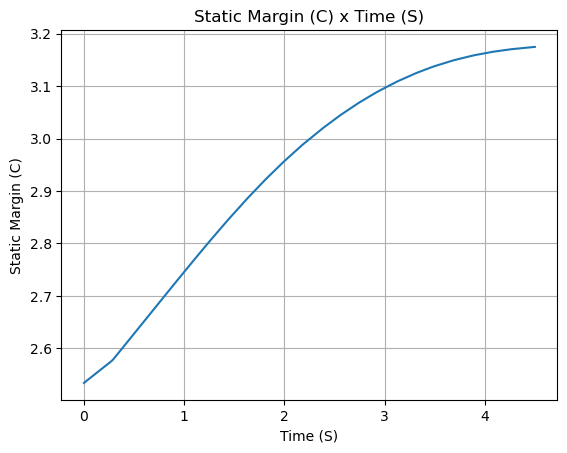

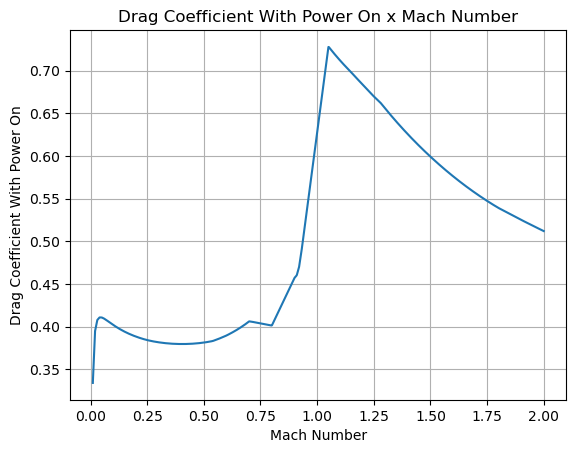

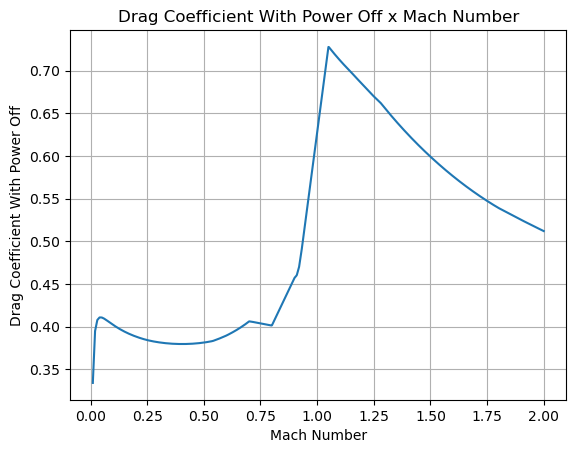

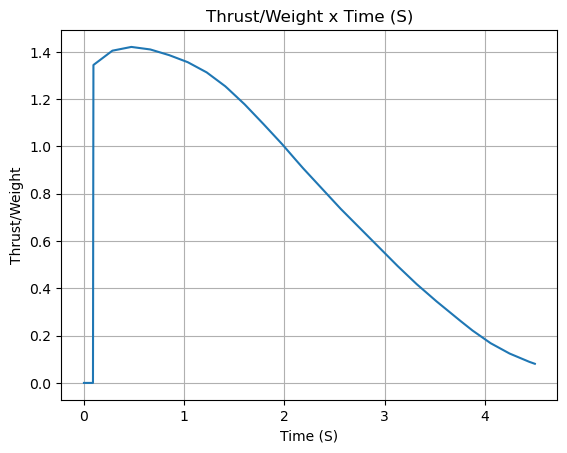

In [23]:
WESP = Rocket(
    motor=J180T, 
    mass = 20, #(kg)
    radius= 0.1, #(m)
    inertiaI=6, #TOB from structures 
    inertiaZ=0.05, #TOB from structures 
    distanceRocketNozzle=1, 
    distanceRocketPropellant=-1, 
    powerOffDrag='../data/rocket/powerOffDragCurve.csv', #TBD 
    powerOnDrag='../data/rocket/powerOnDragCurve.csv', #TBD
)

## Adding Aerodynamic Surfaces 

NoseCone =WESP.addNose(length=0.7, kind="vonKarman", distanceToCM=1.68)

FinSet = WESP.addTrapezoidalFins(
    n= 4,
    span= 0.27,
    rootChord= 0.35, 
    tipChord= 0.08, 
    distanceToCM= -0.86,
    cantAngle= 0, 
    radius= None, 
    airfoil= None,
)

WESP.setRailButtons(distanceToCM= [1.2, 0.9]) #This is randomly chosen to avoid errors -> need more accurate rocket data
# Tail = Rocket.addTail(
#     topRadius=, bottomRadius=, length=, distanceToCM=
# )
WESP.allInfo()

Add Parachutes

In [10]:
def drogueTrigger(p,y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False

def mainTrigger(p,y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False

mainChute =WESP.addParachute(
    "Main", 
    CdS=10.0,
    trigger=mainTrigger, 
    samplingRate=105, 
    lag=1.5, 
    noise=(0,8.3, 0.5)
)

DrogueChute =WESP.addParachute(
    "Drogue", 
    CdS=10.0,
    trigger=mainTrigger, 
    samplingRate=105, 
    lag=1.5, 
    noise=(0,8.3, 0.5)
)

    Simulate Flight

In [24]:
Flight = Flight(
    rocket=WESP, 
    environment=Env,
    inclination= 88, 
    heading=0 
)

Flight.info()

Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


 Rail Departure State

Rail Departure Time: 1.974 s
Rail Departure Velocity: 5.551 m/s
Rail Departure Static Margin: 2.952 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 1.012
Rail Departure Reynolds Number: 1.110e+00


BurnOut State

BurnOut time: 4.500 s
Altitude at burnOut: 9.048 m (AGL)
Rocket velocity at burnOut: 7.220 m/s
Freestream velocity at burnOut: 7.220 m/s
Mach Number at burnOut: 0.021


TypeError: Flight.kineticEnergy() takes 1 positional argument but 2 were given